In [1]:
import kagglehub
import os

path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("path to dataset files:", path)

print("contents of downloaded folder:")
print(os.listdir(path))

path to dataset files: /kaggle/input/animals10
contents of downloaded folder:
['translate.py', 'raw-img']


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")
dataset_path = os.path.join(path, "raw-img")

def load_animal_images(path, max_per_class=1446):
    gray_imgs, color_imgs, labels = [], [], []
    label_map = {}
    current_label = 0
    image_size = (64, 64)

    for folder in sorted(os.listdir(path)):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path): continue

        count = 0
        for file in os.listdir(folder_path):
            if count >= max_per_class:
                break
            file_path = os.path.join(folder_path, file)
            img = cv2.imread(file_path)
            if img is None:
                continue
            try:
                img = cv2.resize(img, image_size)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            except:
                continue

            color_imgs.append(img / 255.0)
            gray_imgs.append(np.expand_dims(gray / 255.0, axis=-1))

            if folder not in label_map:
                label_map[folder] = current_label
                current_label += 1
            labels.append(label_map[folder])
            count += 1

    return (
        np.array(gray_imgs, dtype=np.float32),
        np.array(color_imgs, dtype=np.float32),
        to_categorical(labels, num_classes=current_label),
        label_map
    )

gray_images, color_images, label_cats, label_map = load_animal_images(dataset_path, max_per_class=1446)

gray_train, gray_test, color_train, color_test, y_train, y_test = train_test_split(
    gray_images, color_images, label_cats, test_size=0.2, shuffle=True , random_state=42
)

input_layer = Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(input_layer)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2,2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu")(encoded)
x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
decoded = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same", name="dec_output")(x)

# Classifier
y = layers.Conv2D(32, (3,3), activation="relu", padding="same")(decoded)
y = layers.Conv2D(64, (3,3), activation="relu", padding="same")(y)
y = layers.Conv2D(128, (3,3), activation="relu", padding="same")(y)
y = layers.MaxPooling2D((2,2), padding="same")(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation="relu")(y)
output_class = layers.Dense(len(label_map), activation="softmax", name="class_output")(y)

model = models.Model(inputs=input_layer, outputs=[decoded, output_class])
model.compile(
    optimizer='adam',
    loss={
        'dec_output': 'mse',
        'class_output': 'categorical_crossentropy'
    },
    metrics={'class_output': 'accuracy'}
)
model.summary()

print(f"total images loaded: {len(gray_images)}")
print(f"image shape (grayscale): {gray_images[0].shape}")
print(f"number of classes: {len(label_map)}")
print(f"label map: {label_map}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_output (Conv2D)             │ (None, 64, 64, 3)      │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,388,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_output (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,815,949 (33.63 MB)

 Trainable params: 8,815,949 (33.63 MB)

 Non-trainable params: 0 (0.00 B)

total images loaded: 14460
image shape (grayscale): (64, 64, 1)
number of classes: 10
label map: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [3]:
model.fit(
    x=gray_train,
    y={'dec_output': color_train, 'class_output': y_train},
    epochs=25,
    batch_size=128,
    validation_data=(gray_test, {'dec_output': color_test, 'class_output': y_test})
)

Epoch 1/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 68s 474ms/step - class_output_accuracy: 0.1043 - class_output_loss: 2.3514 - dec_output_loss: 0.0535 - loss: 2.4049 - val_class_output_accuracy: 0.1231 - val_class_output_loss: 2.2754 - val_dec_output_loss: 0.0244 - val_loss: 2.2995
Epoch 2/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 280ms/step - class_output_accuracy: 0.2139 - class_output_loss: 2.1653 - dec_output_loss: 0.0242 - loss: 2.1895 - val_class_output_accuracy: 0.2911 - val_class_output_loss: 1.9750 - val_dec_output_loss: 0.0200 - val_loss: 1.9971
Epoch 3/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - class_output_accuracy: 0.3803 - class_output_loss: 1.8161 - dec_output_loss: 0.0217 - loss: 1.8378 - val_class_output_accuracy: 0.3710 - val_class_output_loss: 1.7974 - val_dec_output_loss: 0.0243 - val_loss: 1.8246
Epoch 4/25
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 280ms/step - class_output_accuracy: 0.5013 - class_output_loss: 1.4826 - dec_output_loss: 0.0238 - loss: 1.5064 - val_class_output_accuracy: 0.39

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


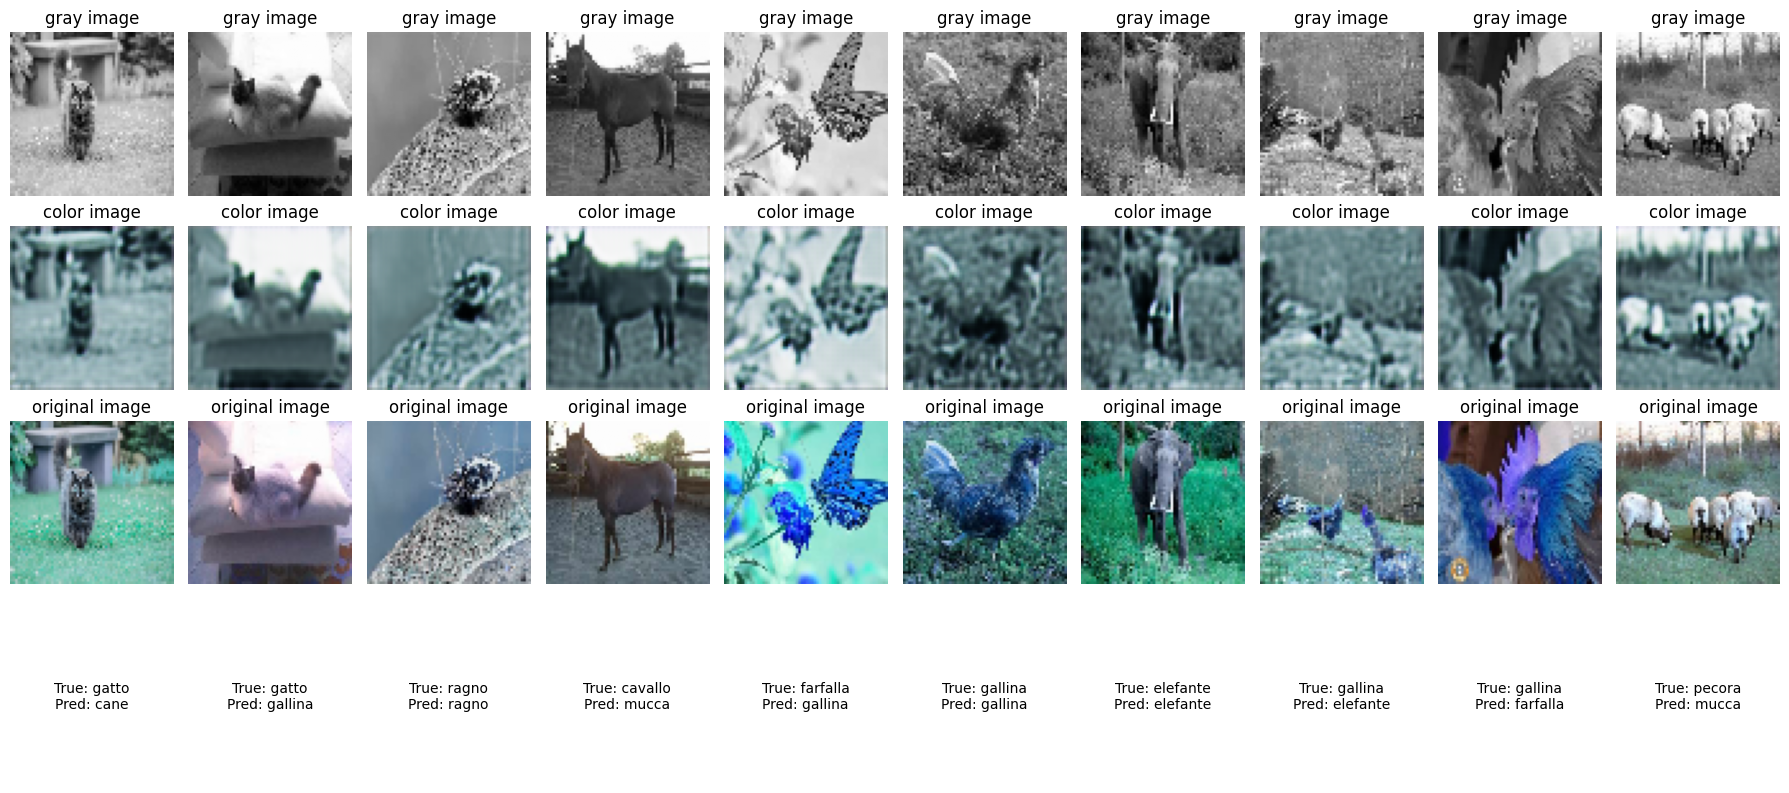

In [6]:
decoded_imgs, class_preds = model.predict(gray_test[:10])
predicted_classes = np.argmax(class_preds, axis=1)
true_classes = np.argmax(y_test[:10], axis=1)

inv_label_map = {v: k for k, v in label_map.items()}

plt.figure(figsize=(18, 8))
for i in range(10):
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(gray_test[i].reshape(64, 64), cmap="gray")
    plt.title("gray image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 11)
    plt.imshow(decoded_imgs[i])
    plt.title("color image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 21)
    plt.imshow(color_test[i])
    plt.title("original image")
    plt.axis("off")

    ax = plt.subplot(4, 10, i + 31)
    plt.text(0.5, 0.5,
             f"True: {inv_label_map[true_classes[i]]}\nPred: {inv_label_map[predicted_classes[i]]}",
             ha="center", va="center", wrap=True)
    plt.axis("off")

plt.tight_layout()
plt.show()